In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import snowflake.connector
import tqdm
import datetime
import timedelta
from time import time

In [5]:
matplotlib.rcParams['figure.figsize'] = (13,8)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 13
%config InlineBackend.figure_format = 'retina'

In [7]:
import os
os.chdir('/Users/jehlokhande/Documents/Data Personal Projects/Spotify/2021/MyData')

In [1]:
!chmod data.csv

usage:	chmod [-fhv] [-R [-H | -L | -P]] [-a | +a | =a  [i][# [ n]]] mode|entry file ...
	chmod [-fhv] [-R [-H | -L | -P]] [-E | -C | -N | -i | -I] file ...


In [ ]:
from s3fs import S3File

### Load Data and Feature Engineering

In [17]:
os.chdir('/Users/jehlokhande/Documents/Data Personal Projects/Spotify/2021/MyData')
stream_2021 = pd.read_json('StreamingHistory0.json')
stream_2021.columns = stream_2021.columns.str.replace(' ', '_').str.lower()
stream_2021['endtime'] = pd.to_datetime(stream_2021['endtime']) 
stream_2021['endtime'] = stream_2021['endtime'].dt.tz_localize('UTC')
stream_2021['endtime'] = stream_2021['endtime'].dt.tz_convert('America/Los_Angeles')
stream_2021['endtime'] = stream_2021['endtime'].dt.tz_localize(None)
stream_2021.head()

,endtime,artistname,trackname,msplayed
0,2020-11-22 16:34:00,Matoma,All Around The World (feat. Bryn Christopher),18780
1,2020-11-22 16:35:00,Matoma,Lonely (feat. MAX),17075
2,2020-11-22 16:35:00,Matoma,Lights Go Down (feat. James Newman),29264
3,2020-11-22 16:38:00,Matoma,Wonderful Life (Mi Oh My) - from The Angry Bir...,210920
4,2020-11-22 16:42:00,The Vamps,All Night,197640


In [18]:
os.chdir('/Users/jehlokhande/Documents/Data Personal Projects/Spotify/2020/MyData')
stream_2020 = pd.read_json('StreamingHistory0.json')
stream_2020.columns = stream_2020.columns.str.replace(' ', '_').str.lower()
stream_2020['endtime'] = pd.to_datetime(stream_2020['endtime']) 
stream_2020['endtime'] = stream_2020['endtime'].dt.tz_localize('UTC')
stream_2020['endtime'] = stream_2020['endtime'].dt.tz_convert('America/Los_Angeles')
stream_2020['endtime'] = stream_2020['endtime'].dt.tz_localize(None)
stream_2020.head()

,endtime,artistname,trackname,msplayed
0,2019-12-02 07:22:00,Tanishk Bagchi,Makhna,10846
1,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,10087
2,2019-12-02 07:25:00,Tanishk Bagchi,Makhna,174703
3,2019-12-02 07:25:00,Anne-Marie,2002,10087
4,2019-12-02 07:25:00,Selena Gomez,Back To You,0


In [19]:
stream = stream_2021.append(stream_2020)

In [20]:
stream['day'] = stream['endtime'].dt.day_name() 
stream['weekday'] = stream['endtime'].dt.weekday
stream['weekend_flag'] = stream['weekday'].apply(lambda x: 1 if x>=5 else 0)
stream['date'] = pd.to_datetime(stream['endtime'].dt.date)

stream['week'] = stream['endtime'].dt.weekofyear
stream['week_date'] = stream['date'].apply(lambda x: x - pd.DateOffset(int(x.weekday())))

stream['month'] = stream['endtime'].dt.month
stream['month_name'] = stream['endtime'].dt.month_name()
stream['day_num'] = stream['date'].dt.day
stream['month_date'] = stream['date'].apply(lambda x: x - pd.DateOffset(int(x.day)-1))

stream['hour'] = stream['endtime'].dt.hour

/Users/jehlokhande/.pyenv/versions/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [21]:
stream['time_min'] = stream['msplayed']/1000/60

stream['lastyear_flag'] = stream['date'].apply(lambda x: 1 if str(x)< '2021-01-01' else 0 )

In [22]:
# stream.to_csv('spotify_data.csv')
stream.head()

,endtime,artistname,trackname,msplayed,day,weekday,weekend_flag,date,week,week_date,month,month_name,day_num,month_date,hour,time_min,lastyear_flag
0,2020-11-22 16:34:00,Matoma,All Around The World (feat. Bryn Christopher),18780,Sunday,6,1,2020-11-22,47,2020-11-16,11,November,22,2020-11-01,16,0.313000,1
1,2020-11-22 16:35:00,Matoma,Lonely (feat. MAX),17075,Sunday,6,1,2020-11-22,47,2020-11-16,11,November,22,2020-11-01,16,0.284583,1
2,2020-11-22 16:35:00,Matoma,Lights Go Down (feat. James Newman),29264,Sunday,6,1,2020-11-22,47,2020-11-16,11,November,22,2020-11-01,16,0.487733,1
3,2020-11-22 16:38:00,Matoma,Wonderful Life (Mi Oh My) - from The Angry Bir...,210920,Sunday,6,1,2020-11-22,47,2020-11-16,11,November,22,2020-11-01,16,3.515333,1
4,2020-11-22 16:42:00,The Vamps,All Night,197640,Sunday,6,1,2020-11-22,47,2020-11-16,11,November,22,2020-11-01,16,3.294000,1


### EDA

1.   Listening time over weeks
2.   Top artists by week over time
3. Top songs by week over time
4. Number of songs by week over time
5. Listening time by day of week
6. ... some more ideas



In [ ]:
### Listening time over the year

Text(0.5, 0, 'Week')

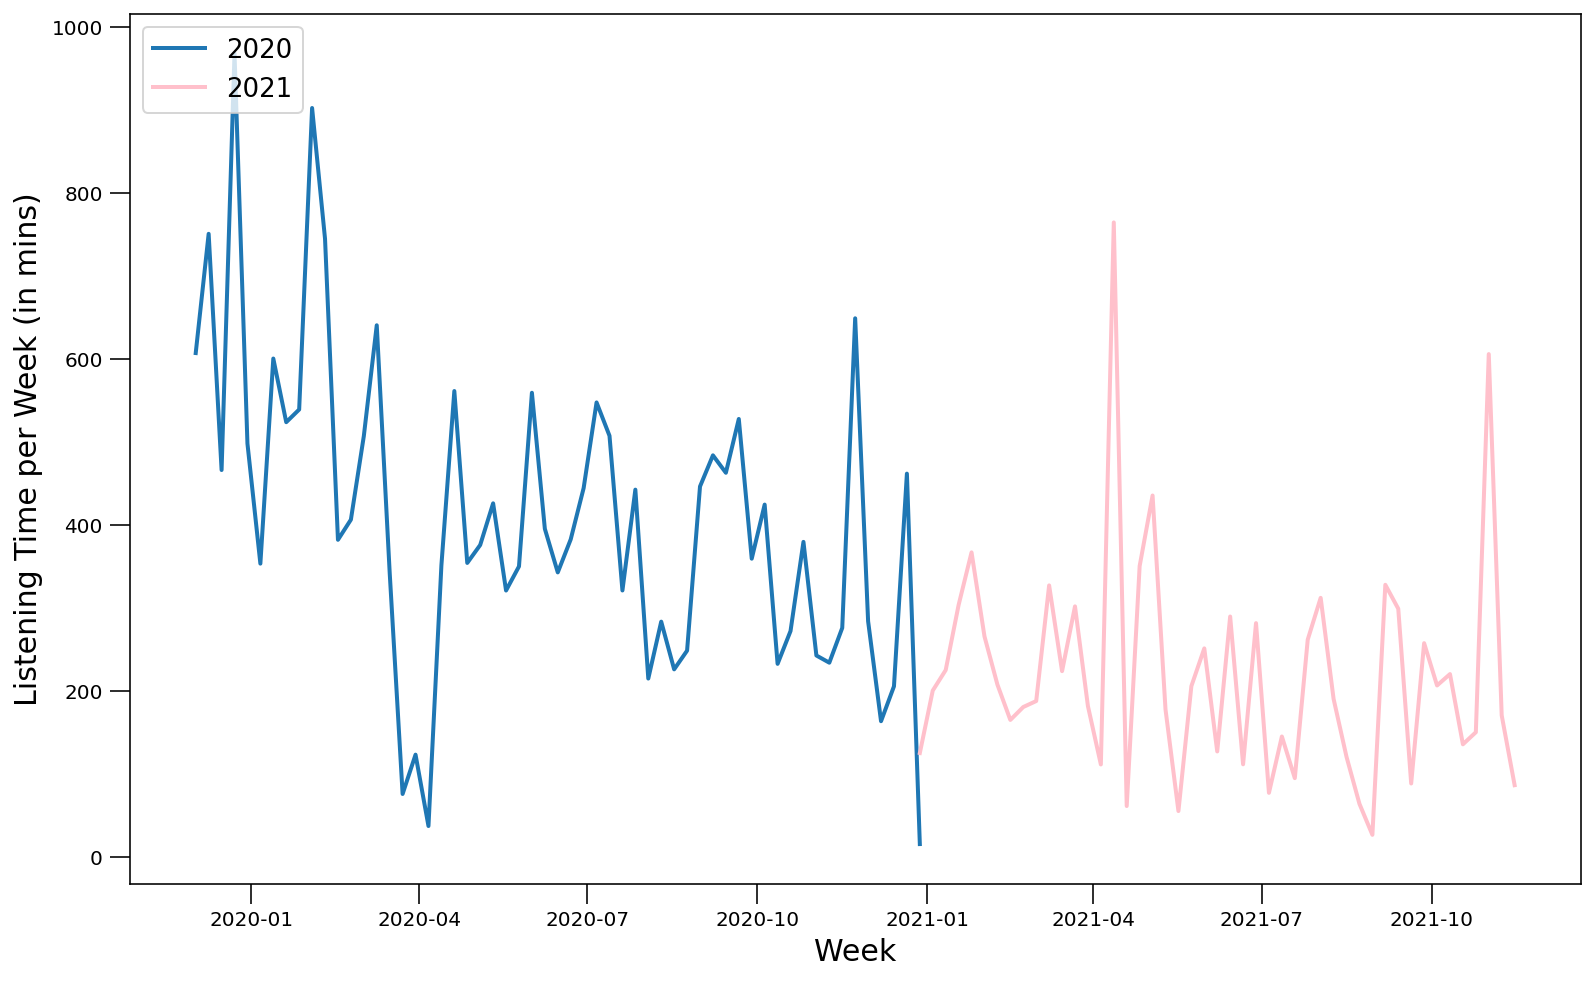

In [49]:
weekly_stream = stream.groupby(by = ['lastyear_flag', 'week', 'week_date'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
weekly_stream.head()

ax1 = sns.lineplot(data = weekly_stream.query('lastyear_flag == 1'), x = 'week_date', y = 'time_min', label='2020')
# ax2 = plt.twinx()
sns.lineplot(data = weekly_stream.query('lastyear_flag == 0'), x = 'week_date', y = 'time_min', color = 'Pink',label='2021')
# sns.lineplot(data=weekly_stream, x = 'week_date', y = 'trackname', color="r", ax=ax2, label='Number of Songs')


ax1.legend(loc = 'upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Listening Time per Week (in mins)')
# ax2.set_ylabel('Number of Songs per Week')
ax1.set_xlabel('Week')


In [50]:
weekly_stream.groupby(by = ['lastyear_flag'], as_index = False).agg({'time_min':'mean'})

,lastyear_flag,time_min
0,0,219.927054
1,1,408.066680


In [24]:
hourly_stream = stream.groupby(by = ['date','hour'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
hourly_stream['hour_2'] = np.round(hourly_stream['hour']/4)*4
hourly_stream.head()

,date,hour,time_min,trackname,hour_2
0,2019-12-02,7,37.150900,22,8.0
1,2019-12-02,8,36.915100,11,8.0
2,2019-12-02,15,9.962317,4,16.0
3,2019-12-02,16,12.160950,5,16.0
4,2019-12-03,8,10.263933,14,8.0


([<matplotlib.axis.XTick at 0x134dad3c8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

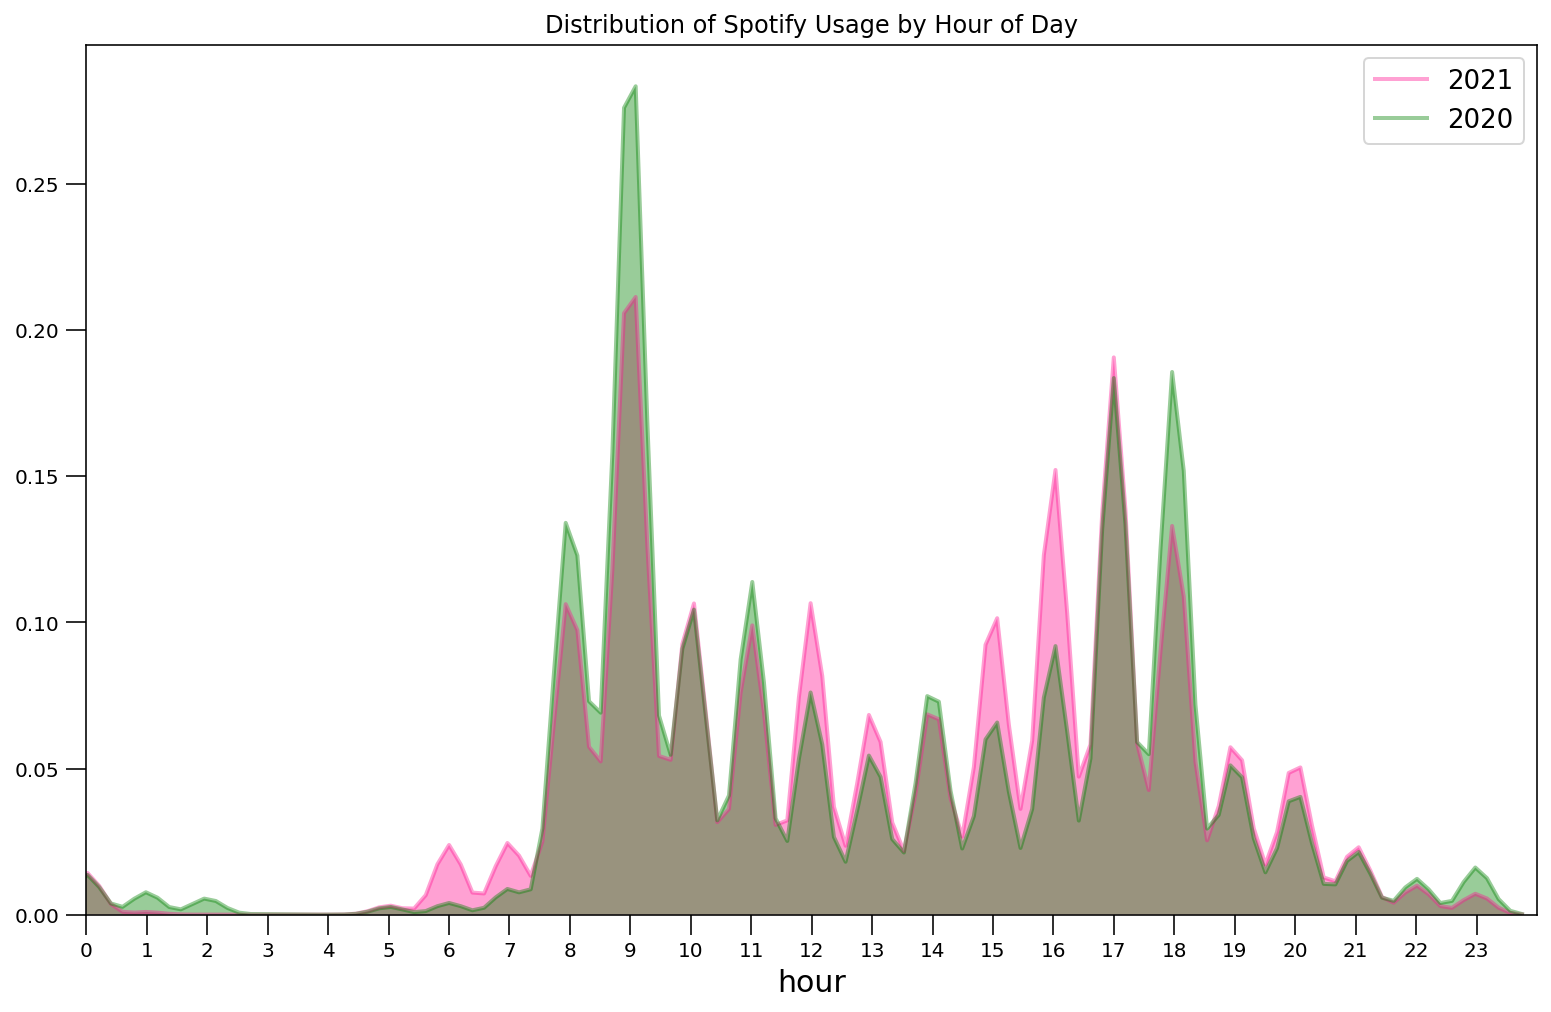

In [28]:
### Histogram of listening time across hour of day

sns.distplot(stream.query('lastyear_flag==0')['hour'], label = '2021', color = 'deeppink',kde_kws={'bw':0.25, 'shade':True, 'alpha':0.4}, hist = False)
sns.distplot(stream.query('lastyear_flag==1')['hour'], label = '2020', color = 'green', kde_kws={'bw':0.25, 'shade':True,  'alpha':0.4}, hist = False)
plt.legend()
plt.title('Distribution of Spotify Usage by Hour of Day')
plt.xlim(0,24)
plt.xticks(np.arange(0,24,1))

([<matplotlib.axis.XTick at 0x134951fd0>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

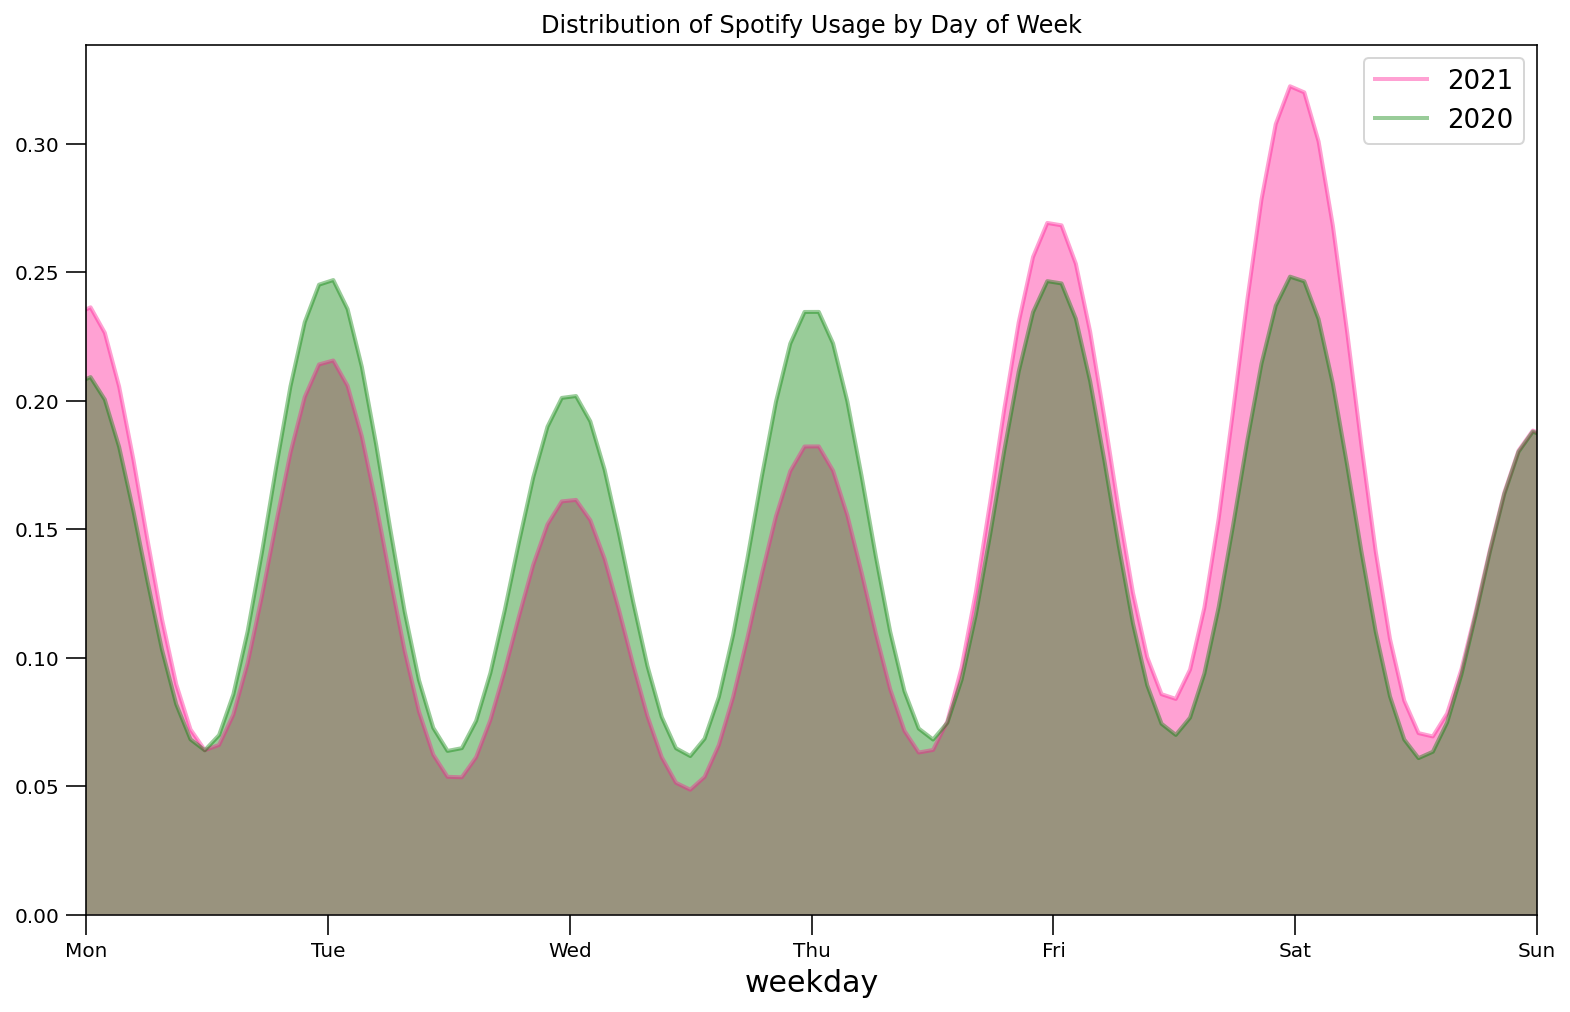

In [27]:
### Histogram of listening time across day of week

sns.distplot(stream.query('lastyear_flag==0')['weekday'], label = '2021', color = 'deeppink', bins = 7, kde_kws={'bw':0.25, 'shade':True, 'alpha':0.4}, hist = False)
sns.distplot(stream.query('lastyear_flag==1')['weekday'], label = '2020', color = 'green', bins = 7, kde_kws={'bw':0.25, 'shade':True, 'alpha':0.4}, hist = False)
plt.legend()
plt.title('Distribution of Spotify Usage by Day of Week')
plt.xlim(0,6)

plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))

In [30]:
daily_stream = stream.groupby(by = ['date', 'lastyear_flag'], as_index = False).agg({'time_min':'sum', 'trackname':'count'})
daily_stream.head()

,date,lastyear_flag,time_min,trackname
0,2019-12-02,1,96.189267,42
1,2019-12-03,1,27.461867,15
2,2019-12-04,1,54.550350,26
3,2019-12-05,1,46.344883,20
4,2019-12-06,1,218.395467,83


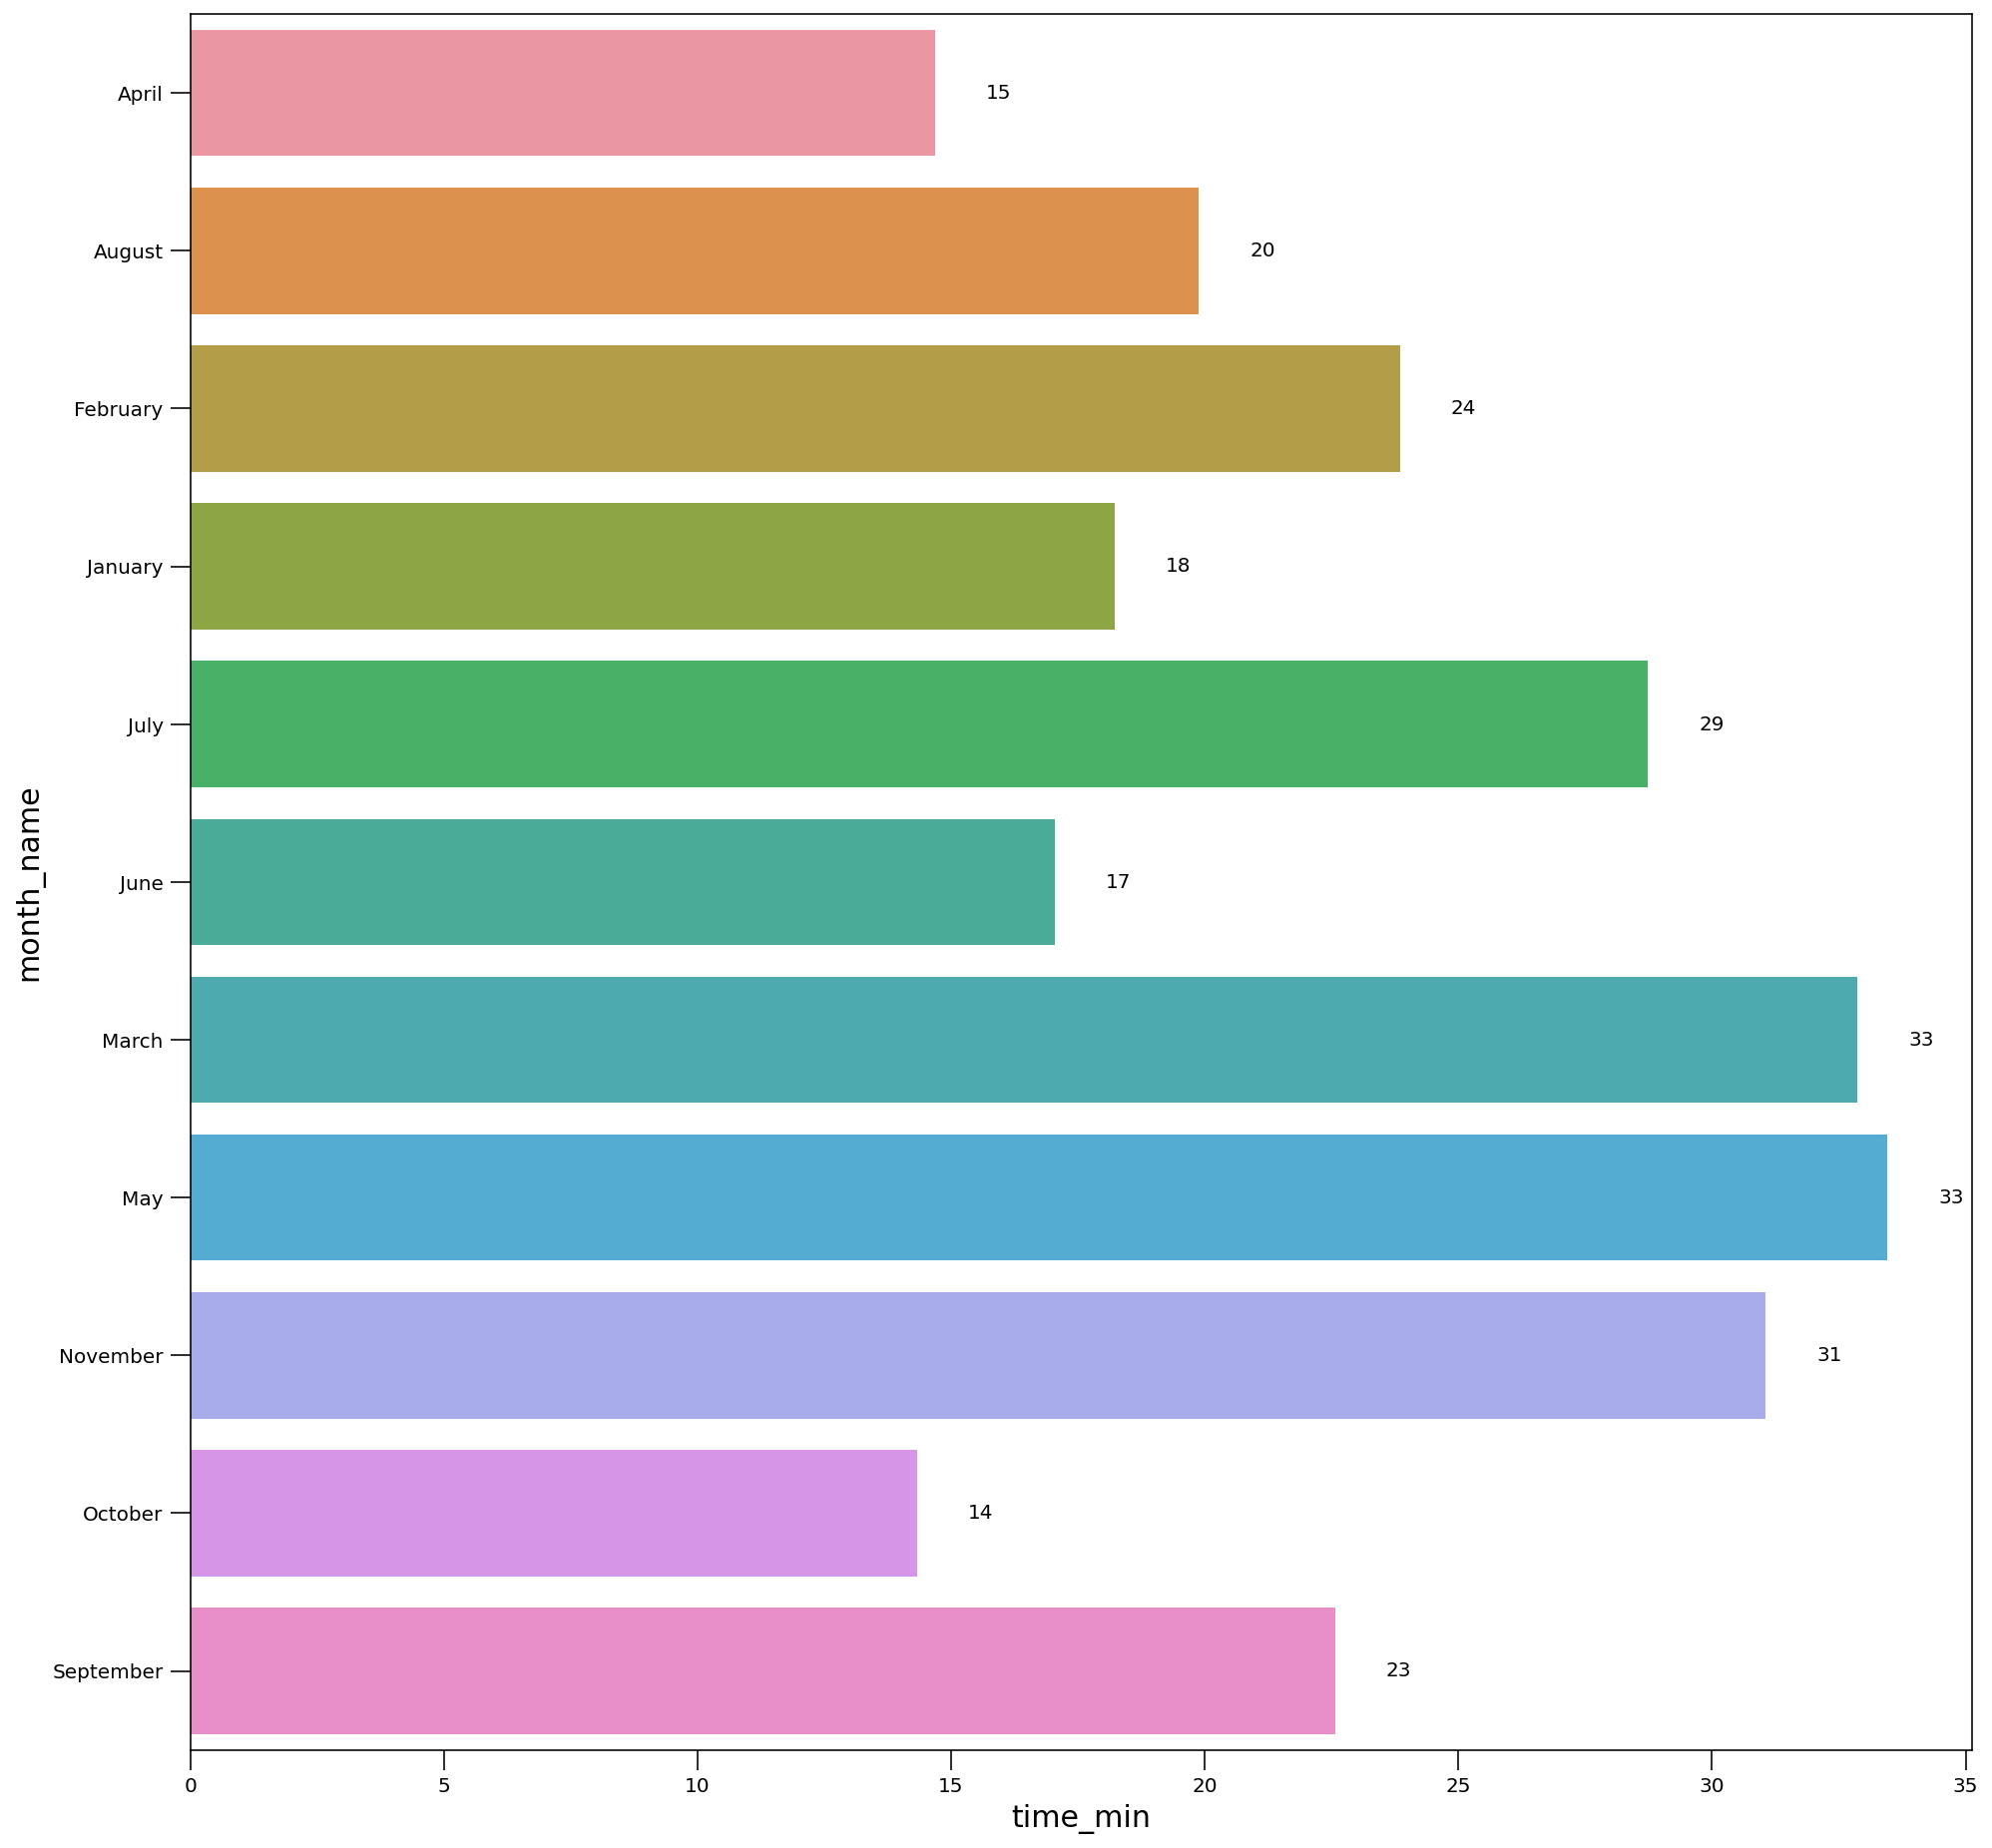

In [34]:
#Top streams every month

plt.figure(figsize = (16,16))
monthly_stream = stream.query('lastyear_flag ==0').groupby(by = ['month_name', 'month_date', 'trackname'], as_index = False).agg({'time_min':'sum', 'endtime':'count'})
monthly_stream.head()

monthly_stream_max = monthly_stream[monthly_stream.groupby(by = ['month_name', 'month_date'])['time_min'].transform(max) == monthly_stream['time_min']]
ax = sns.barplot(data = monthly_stream_max, y = 'month_name', x = 'time_min', orient = 'h', ci = False)


# label each bar in barplot
for p in ax.patches:
 height = p.get_height() # height of each horizontal bar is the same
 width = p.get_width() # width (average number of passengers)
 # adding text to each bar
 ax.text(x = width+1, # x-coordinate position of data label, padded 3 to right of bar
 y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
 s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
 va = 'center') # sets vertical alignment (va) to center

Text(0.5, 53.5, '2021')

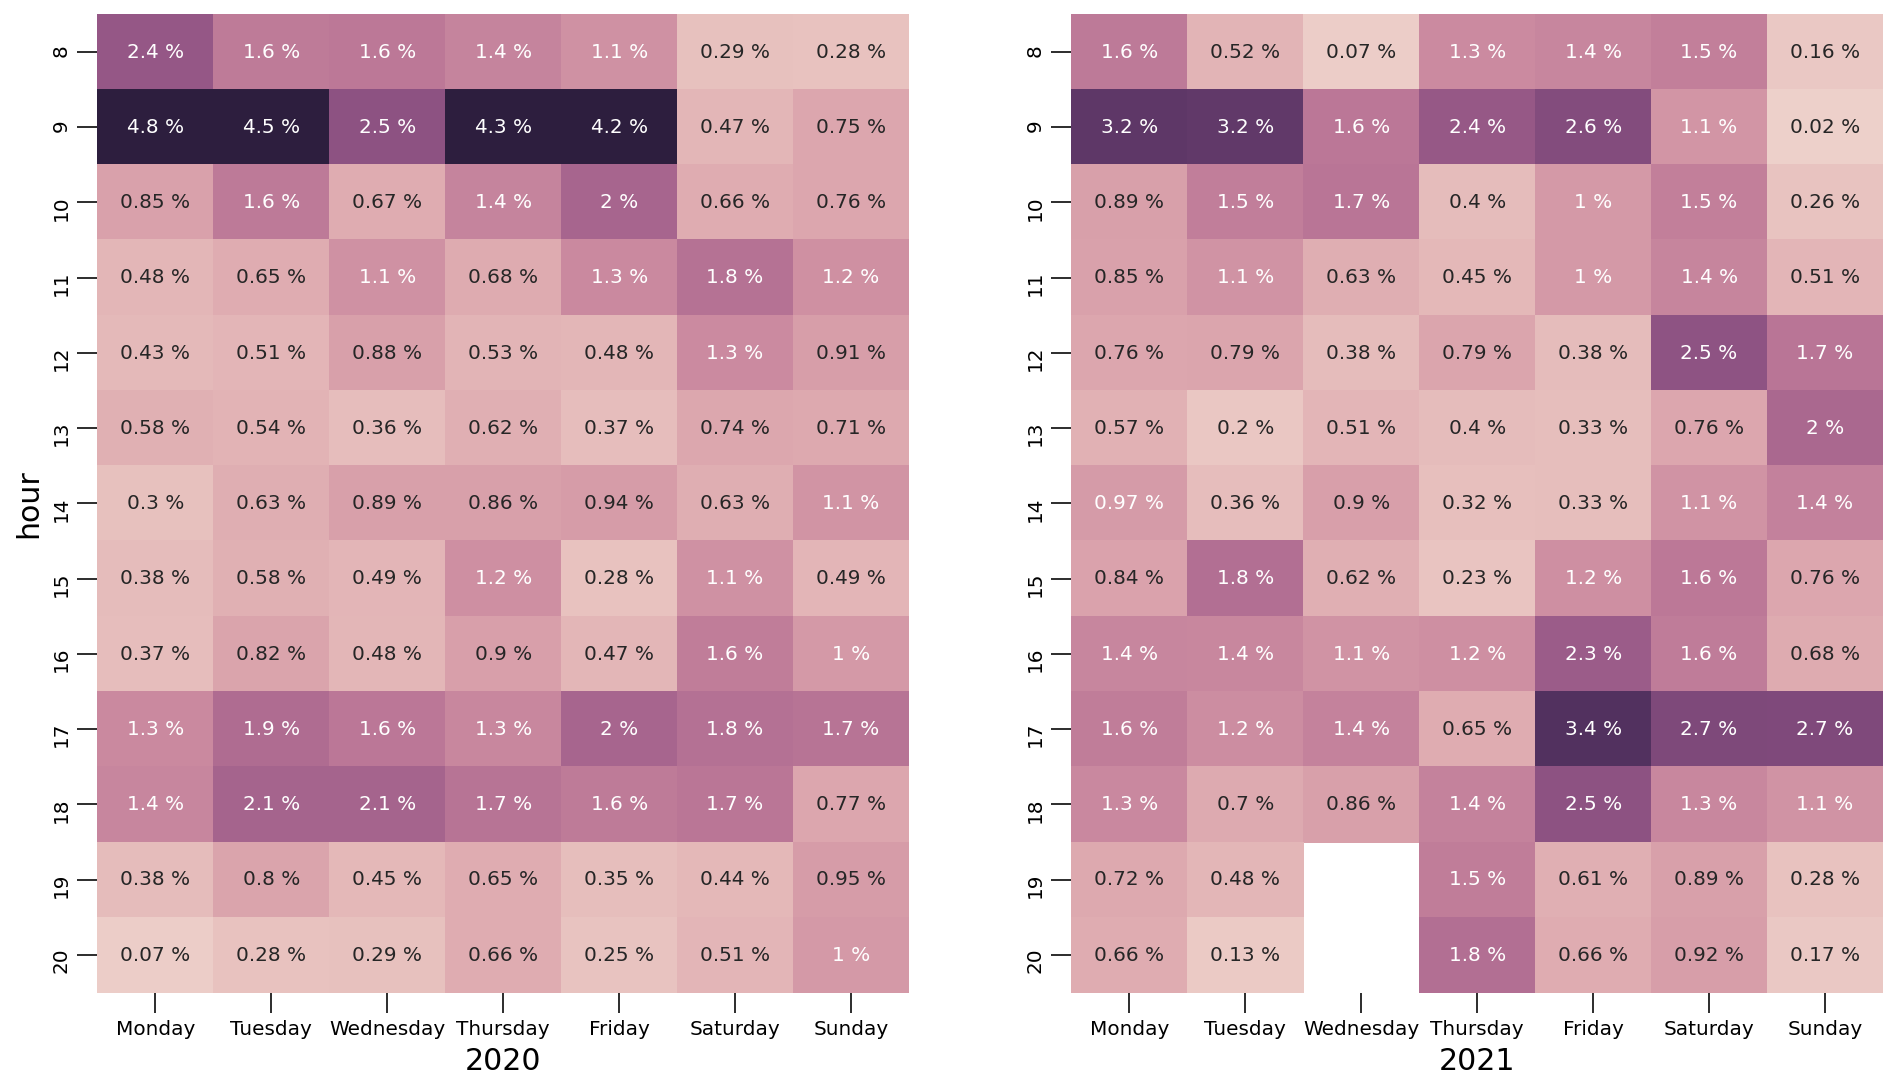

In [37]:
day_hour_pre = stream.query('hour >= 8 and hour <= 20 and lastyear_flag == 1').groupby(by = ['lastyear_flag', 'day', 'hour'], as_index = False).agg({'time_min':'sum'})
day_hour_pre['perc_time'] = np.round(100*day_hour_pre['time_min']/np.sum(day_hour_pre['time_min']),2)
day_hour_pre.drop(columns = ['time_min'], inplace = True)
# day_hour_pre.head()

day_hour_during = stream.query('hour >= 8 and hour <= 20 and lastyear_flag == 0').groupby(by = ['lastyear_flag', 'day', 'hour'], as_index = False).agg({'time_min':'sum'})
day_hour_during['perc_time'] = np.round(100*day_hour_during['time_min']/np.sum(day_hour_during['time_min']),2)
day_hour_during.drop(columns = ['time_min'], inplace = True)
# day_hour_during.head()

##Heatmap of categories over weekday
plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (16,9))
plt.subplot(1,2,1)
result = day_hour_pre.query('lastyear_flag == 1').pivot(index='hour', columns='day', values='perc_time')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
ax = sns.heatmap(result, cmap = sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=4, annot=True, annot_kws={"size": 10}, cbar = False)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.xlabel('2020')
# a2.set(xlabel='Category', ylabel='Day of the Week (0 - Mon, 6 - Sun)')
# plt.show(a2)

plt.subplot(1,2,2)
result = day_hour_during.query('lastyear_flag == 0').pivot(index='hour', columns='day', values='perc_time')[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
ax2 = sns.heatmap(result, cmap = sns.cubehelix_palette(as_cmap=True), vmin=0, vmax = 4, annot=True, annot_kws={"size": 10}, cbar = False)
for t in ax2.texts: t.set_text(t.get_text() + " %")
plt.ylabel('')
plt.xlabel('2021')
# a2.set(xlabel='Category', ylabel='Day of the Week (0 - Mon, 6 - Sun)')


<AxesSubplot:xlabel='trackname', ylabel='artistname'>

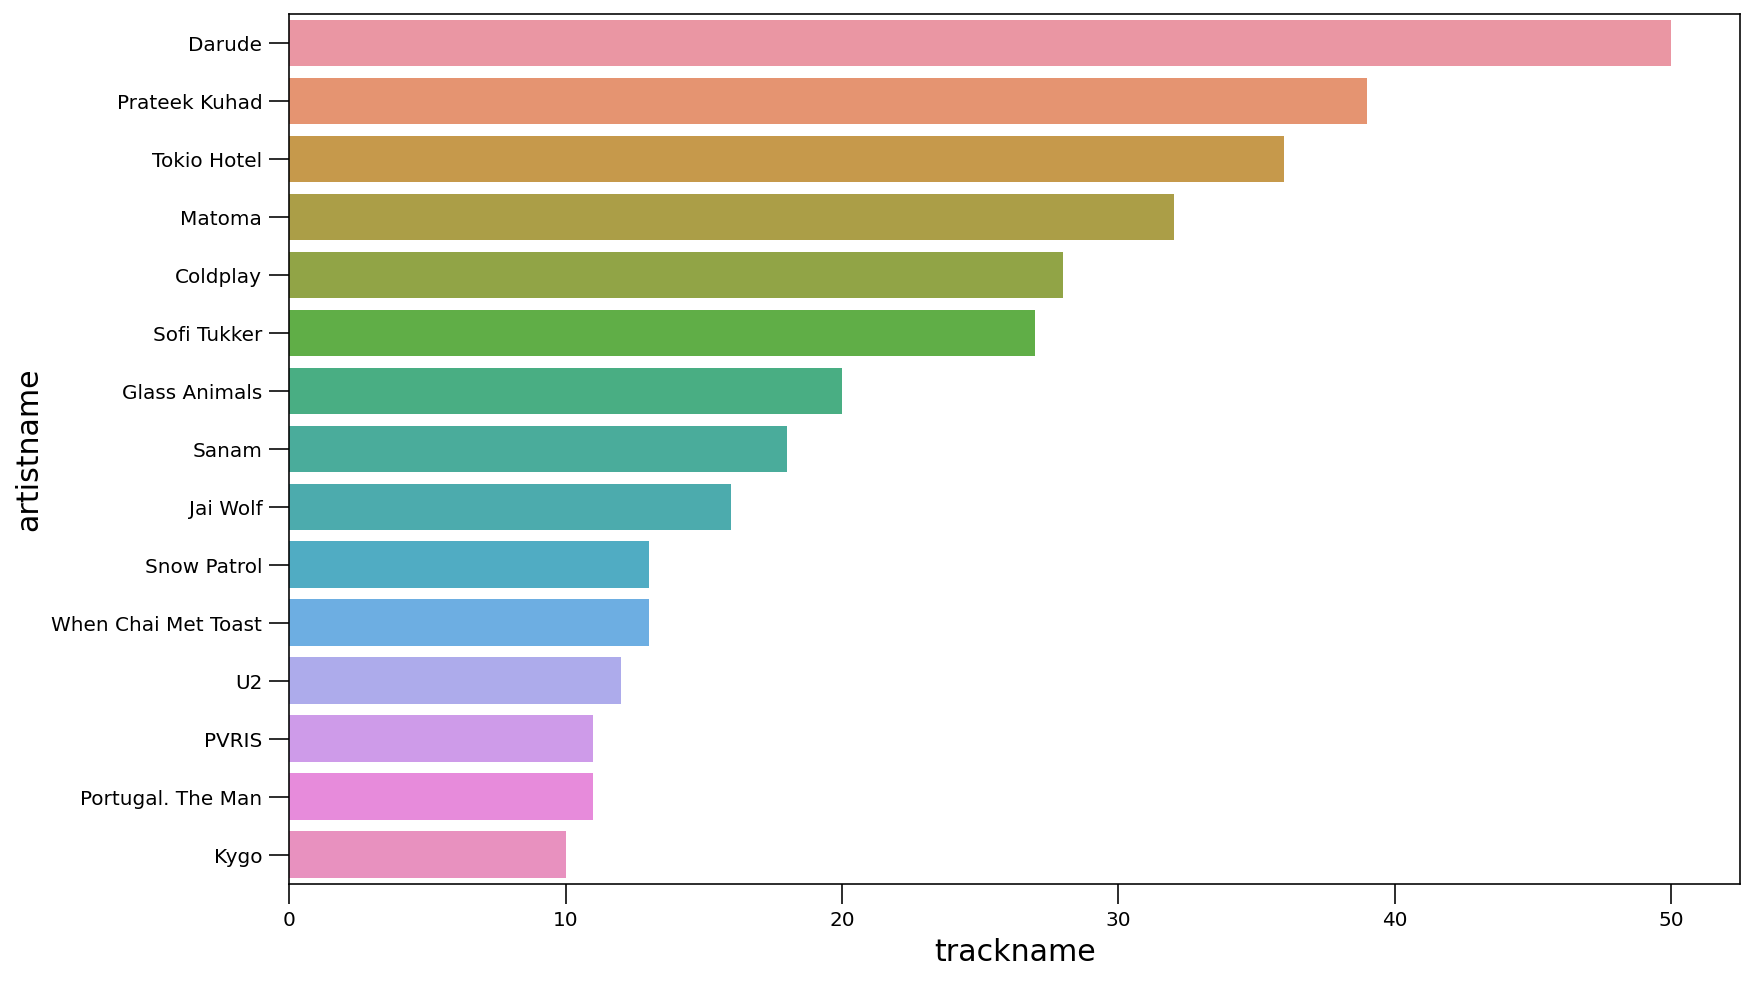

In [51]:
#Songs per artist

sns.barplot(data = stream.query('lastyear_flag == 0').groupby(by = 'artistname', as_index=False).agg({'trackname':'nunique'}).sort_values(by = 'trackname', ascending=False)[:15], y = 'artistname', x = 'trackname', orient = 'h')

<AxesSubplot:xlabel='trackname', ylabel='artistname'>

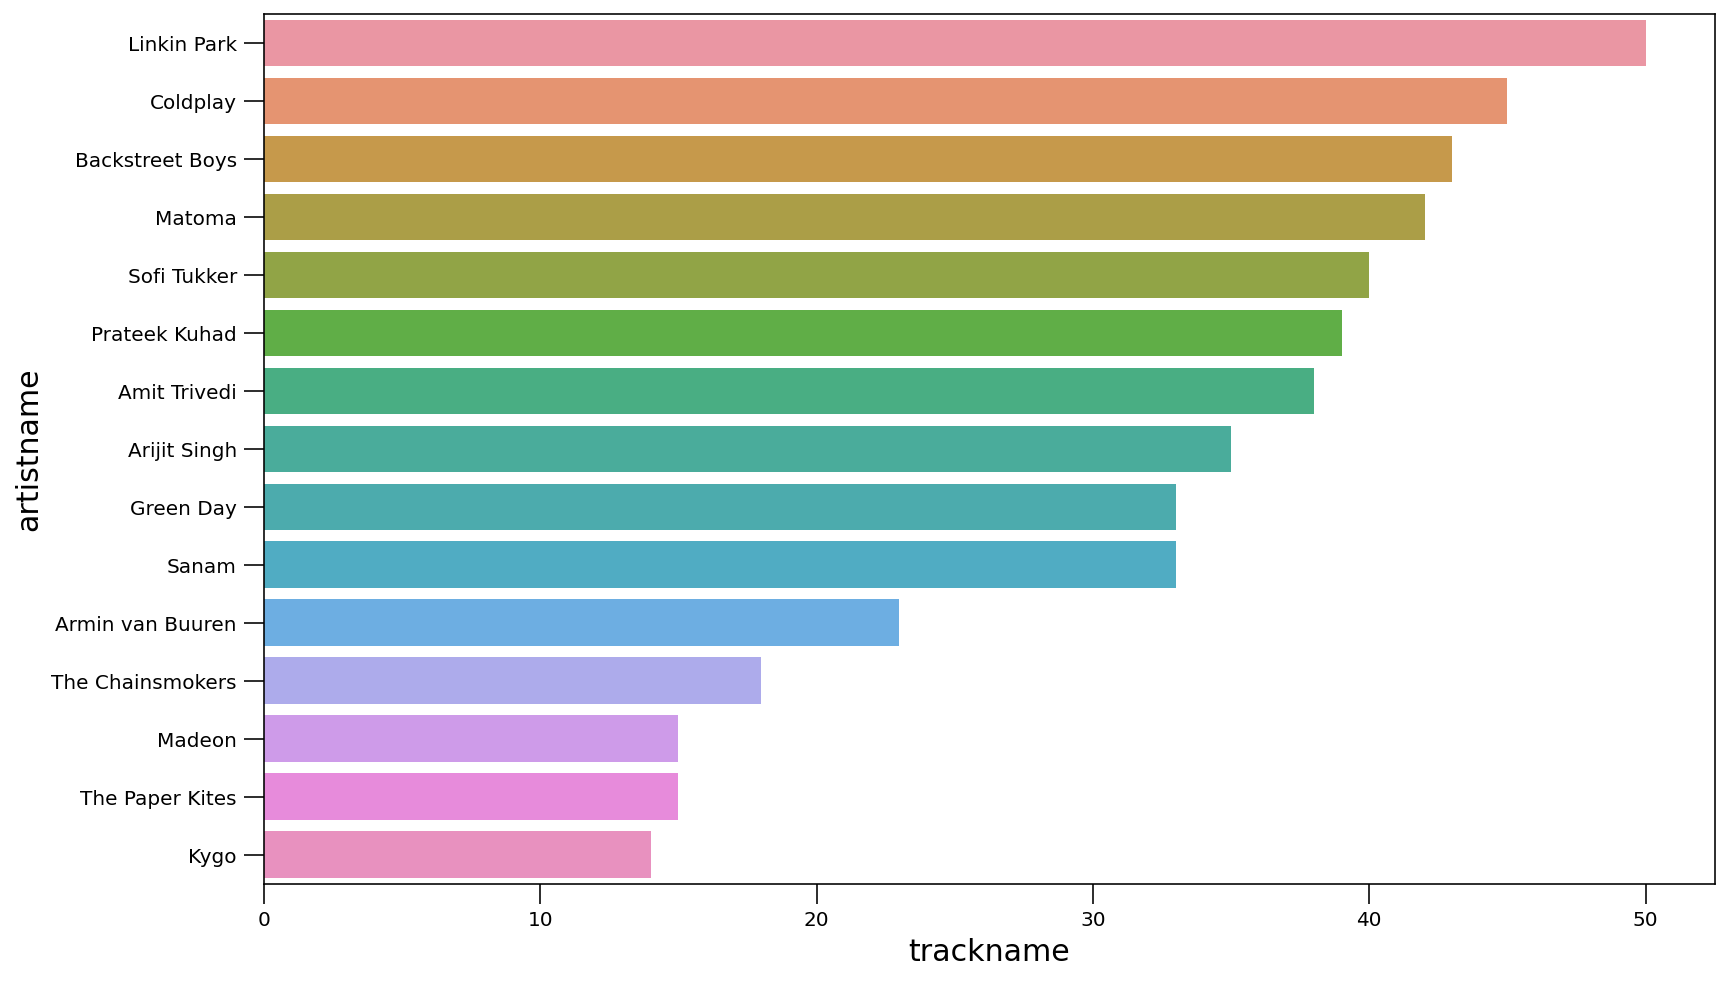

In [52]:
#Songs per artist

sns.barplot(data = stream.query('lastyear_flag == 1').groupby(by = 'artistname', as_index=False).agg({'trackname':'nunique'}).sort_values(by = 'trackname', ascending=False)[:15], y = 'artistname', x = 'trackname', orient = 'h')

In [39]:
stream_top_artists = stream.query('lastyear_flag == 0').groupby(by = 'artistname', as_index=False).agg({'time_min':'sum'}).sort_values(by = 'time_min', ascending=False)[:25].reset_index()
stream_top_artists['index'] = stream_top_artists.index

<AxesSubplot:xlabel='index', ylabel='time_min'>

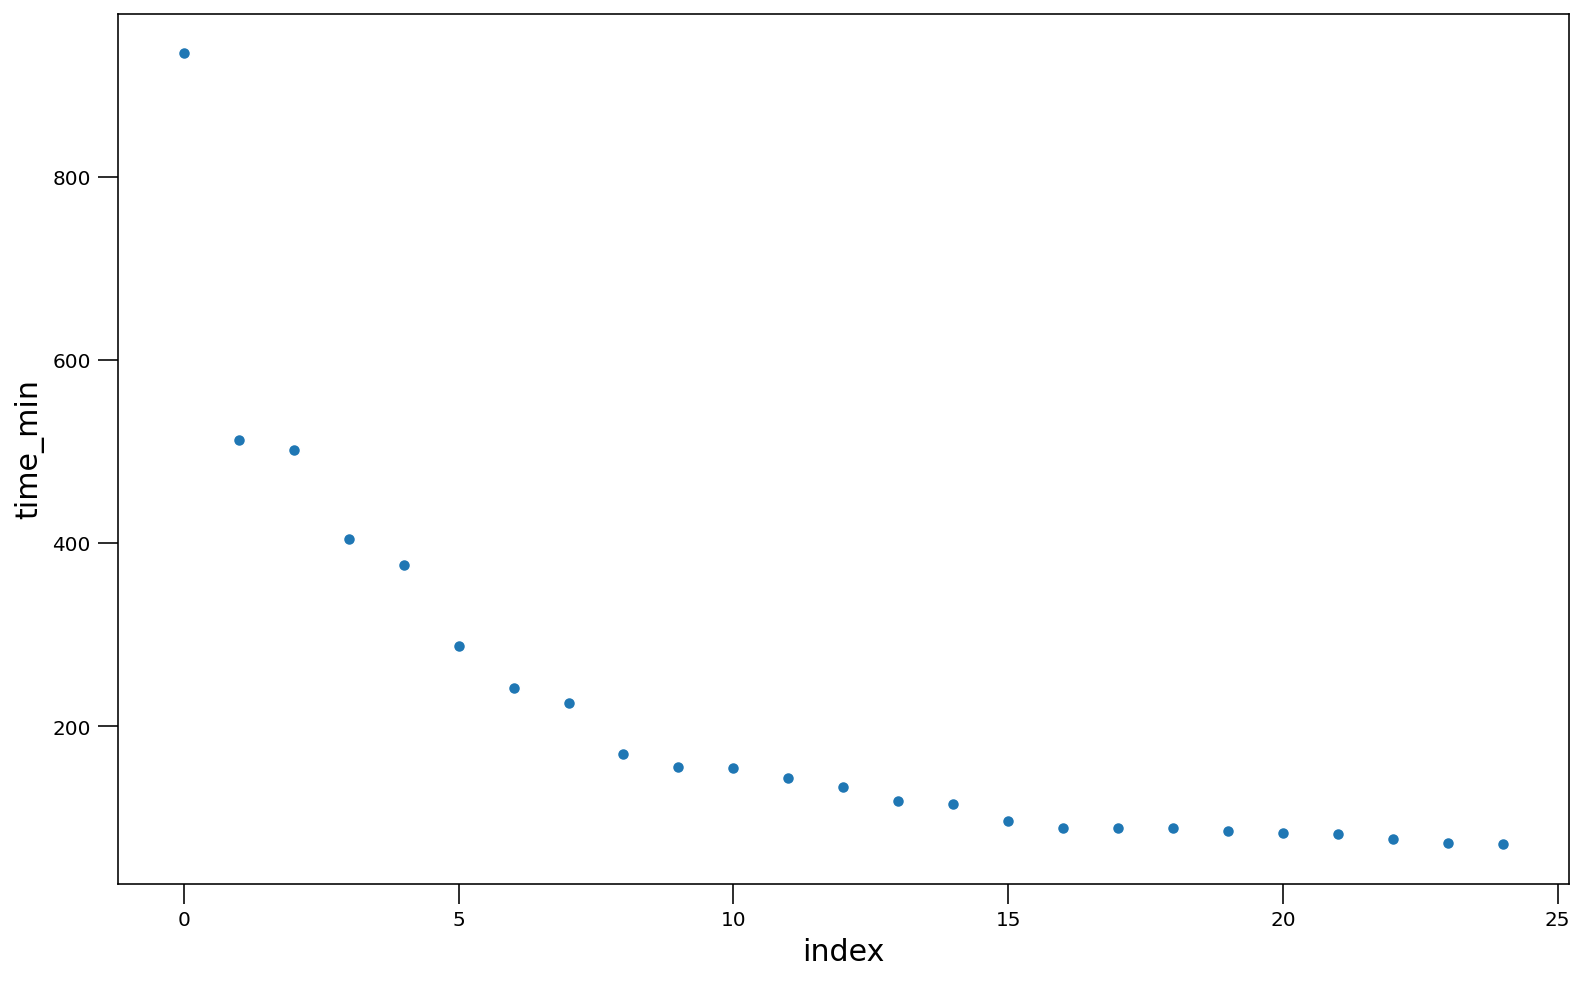

In [40]:
sns.scatterplot(data = stream_top_artists, x = 'index', y = 'time_min')

In [41]:
stream_top_artists

,index,artistname,time_min
0,0,Prateek Kuhad,935.259833
1,1,When Chai Met Toast,513.192067
2,2,The Local Train,501.994883
3,3,Coldplay,405.200417
4,4,Darude,376.702100
5,5,Matoma,288.439283
6,6,Sanam,241.492233
7,7,Sofi Tukker,225.805867
8,8,Kygo,169.562983
9,9,U2,156.178767
